In [3]:
import os
import sys
import json
import numpy as np
import pickle
from typing import List, Tuple, Dict, Any
from pathlib import Path
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
MODEL_NAME = "qwen-15b"

In [4]:
thought_anchors_path = Path("..") / "thought-anchors" / "whitebox-analyses"
sys.path.insert(0, str(thought_anchors_path))

from attention_analysis.attn_funcs import (
    get_avg_attention_matrix,
    get_vertical_scores,
    get_sentence_token_boundaries,
)
from attention_analysis.receiver_head_funcs import get_3d_ar_kurtosis, get_top_k_layer_head_kurts, get_all_heads_vert_scores
from pytorch_models.model_config import model2layers_heads

thought_branches_path = Path("..") / "thought-branches" / "blackmail"

from utils import split_solution_into_chunks

print("Imports successful!")

Imports successful!


## Load Data

In [5]:
data_path = "../data/filtered_traces_50.json"
with open(data_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

blackmail_traces = data['blackmail_traces']
acceptance_traces = data['acceptance_traces']
metadata = data['metadata']

print(f"Blackmail traces: {len(blackmail_traces)}")
print(f"Acceptance traces: {len(acceptance_traces)}")
print(f"Source: {metadata['source']}")

Blackmail traces: 50
Acceptance traces: 50
Source: uzaymacar/blackmail-rollouts (base_solutions.json only)


## Helper Functions

In [6]:
def extract_prompt_and_scratchpad(text):
    start_tag = "<SCRATCHPAD_REASONING>"
    end_tag = "</SCRATCHPAD_REASONING>"

    end_index = text.find(end_tag)
    
    # If not found, try <think> tags
    if end_index == -1:
        start_tag = "<think>"
        end_tag = "</think>"
        end_index = text.find(end_tag)
        
    if end_index == -1:
        return None, None  # No reasoning tags found

    start_index = text.rfind(start_tag, 0, end_index)

    if start_index == -1:
        return None, None

    prompt = text[:start_index].strip()
    content_start = start_index + len(start_tag)
    content = text[content_start:end_index].strip()

    return prompt, content

def prepare_inputs_for_analysis(full_text):
    prompt, scratchpad = extract_prompt_and_scratchpad(full_text)
    
    if not prompt or not scratchpad:
        print("Warning: no prompt or no scratchpad found!")
        return None, None
    
    scratchpad_normalized = ' '.join(scratchpad.split())
    
    sentences_list = split_solution_into_chunks(scratchpad_normalized)
    return scratchpad_normalized, sentences_list 

## Quantitative Attention Metrics Across Traces

In [9]:
import numpy as np
from scipy import stats
from scipy.stats import linregress
import pandas as pd

def get_attention_statistics_for_head(trace_dict, layer, head, model_name):
    """Get attention statistics for a single trace and head."""
    text, sentences = prepare_inputs_for_analysis(trace_dict["trace"])
    
    if text is None or sentences is None or len(sentences) < 5:
        return None
    
    # Get attention matrix
    avg_mat = get_avg_attention_matrix(
        text,
        model_name=model_name,
        layer=layer,
        head=head,
        cache_dir="attention_cache",
        sentences=sentences
    )
    
    # Compute vertical scores
    vert_scores = get_vertical_scores(
        avg_mat,
        proximity_ignore=2,
        control_depth=False,
        score_type="mean"
    )
    
    # Remove NaNs
    valid_scores = vert_scores[~np.isnan(vert_scores)]
    if len(valid_scores) < 3:
        return None
    
    # Compute statistics
    top_k = min(5, len(vert_scores))
    top_indices = np.argsort(vert_scores)[-top_k:][::-1]
    
    # Position analysis: where are the anchors located?
    relative_positions = [idx / len(sentences) for idx in top_indices]
    
    stats_dict = {
        'n_sentences': len(sentences),
        'kurtosis': stats.kurtosis(vert_scores, fisher=True, nan_policy='omit'),
        'max_score': np.nanmax(vert_scores),
        'top_3_concentration': np.nansum(np.sort(vert_scores)[-3:]) / np.nansum(vert_scores),
        'entropy': -np.nansum(vert_scores * np.log(vert_scores + 1e-10)),
        'top_anchor_indices': top_indices,
        'top_anchor_relative_pos': relative_positions,
        'mean_anchor_position': np.mean(relative_positions)
    }
    
    return stats_dict


def aggregate_attention_statistics(traces, layer, head, model_name, condition_name):
    """Aggregate attention statistics across all traces for a given head."""
    all_stats = []
    
    print(f"\nProcessing {condition_name} traces for Layer {layer}, Head {head}...")
    
    for i, trace_dict in enumerate(traces):
        stats_dict = get_attention_statistics_for_head(
            trace_dict, layer, head, model_name
        )
        
        if stats_dict is not None:
            all_stats.append(stats_dict)
    
    print(f"  Processed {len(all_stats)}/{len(traces)} valid traces")
    
    if len(all_stats) == 0:
        return None
    
    # Aggregate statistics
    aggregated = {
        'n_traces': len(all_stats),
        'kurtosis_mean': np.mean([s['kurtosis'] for s in all_stats]),
        'kurtosis_std': np.std([s['kurtosis'] for s in all_stats]),
        'max_score_mean': np.mean([s['max_score'] for s in all_stats]),
        'top_3_concentration_mean': np.mean([s['top_3_concentration'] for s in all_stats]),
        'entropy_mean': np.mean([s['entropy'] for s in all_stats]),
        'mean_anchor_position_mean': np.mean([s['mean_anchor_position'] for s in all_stats]),
        'mean_anchor_position_std': np.std([s['mean_anchor_position'] for s in all_stats]),
        'all_stats': all_stats
    }
    
    return aggregated


def length_controlled_comparison(blackmail_agg, acceptance_agg, metric_name):
    """
    Compare a metric between conditions while controlling for trace length.
    
    Uses partial correlation approach:
    1. Regress metric on length within each condition
    2. Compare residuals (length-adjusted values) between conditions
    
    Returns both raw and length-controlled statistics.
    """
    if blackmail_agg is None or acceptance_agg is None:
        return None
    
    # Extract data
    bm_stats = blackmail_agg['all_stats']
    acc_stats = acceptance_agg['all_stats']
    
    bm_lengths = np.array([s['n_sentences'] for s in bm_stats])
    acc_lengths = np.array([s['n_sentences'] for s in acc_stats])
    
    bm_values = np.array([s[metric_name] for s in bm_stats])
    acc_values = np.array([s[metric_name] for s in acc_stats])
    
    # Combine data for overall regression
    all_lengths = np.concatenate([bm_lengths, acc_lengths])
    all_values = np.concatenate([bm_values, acc_values])
    all_conditions = np.concatenate([np.zeros(len(bm_lengths)), np.ones(len(acc_lengths))])
    
    # Method 1: Regress out length effect from the combined data
    slope, intercept, r_value, p_value, std_err = linregress(all_lengths, all_values)
    
    # Compute residuals (length-adjusted values)
    bm_residuals = bm_values - (slope * bm_lengths + intercept)
    acc_residuals = acc_values - (slope * acc_lengths + intercept)
    
    # Compare residuals
    t_stat_controlled, p_val_controlled = stats.ttest_ind(bm_residuals, acc_residuals)
    
    # Also do raw comparison for reference
    t_stat_raw, p_val_raw = stats.ttest_ind(bm_values, acc_values)
    
    # Correlation between length and metric
    bm_corr, bm_corr_p = stats.pearsonr(bm_lengths, bm_values)
    acc_corr, acc_corr_p = stats.pearsonr(acc_lengths, acc_values)
    
    results = {
        'metric': metric_name,
        'bm_mean_raw': np.mean(bm_values),
        'acc_mean_raw': np.mean(acc_values),
        'bm_mean_adjusted': np.mean(bm_residuals),
        'acc_mean_adjusted': np.mean(acc_residuals),
        't_stat_raw': t_stat_raw,
        'p_val_raw': p_val_raw,
        't_stat_controlled': t_stat_controlled,
        'p_val_controlled': p_val_controlled,
        'length_effect_slope': slope,
        'length_effect_p': p_value,
        'bm_length_corr': bm_corr,
        'bm_length_corr_p': bm_corr_p,
        'acc_length_corr': acc_corr,
        'acc_length_corr_p': acc_corr_p,
        'bm_mean_length': np.mean(bm_lengths),
        'acc_mean_length': np.mean(acc_lengths)
    }
    
    return results


def print_length_controlled_analysis(blackmail_agg, acceptance_agg):
    """Print comprehensive length-controlled comparison for all metrics."""
    
    print(f"\n{'='*70}")
    print("LENGTH-CONTROLLED ANALYSIS")
    print(f"{'='*70}")
    
    # Print length distributions
    bm_lengths = [s['n_sentences'] for s in blackmail_agg['all_stats']]
    acc_lengths = [s['n_sentences'] for s in acceptance_agg['all_stats']]
    
    print(f"\nTrace Length Distribution:")
    print(f"  Blackmail: {np.mean(bm_lengths):.1f} ± {np.std(bm_lengths):.1f} sentences")
    print(f"  Acceptance: {np.mean(acc_lengths):.1f} ± {np.std(acc_lengths):.1f} sentences")
    
    t_length, p_length = stats.ttest_ind(bm_lengths, acc_lengths)
    print(f"  Length difference: t = {t_length:.3f}, p = {p_length:.4f}")
    if p_length < 0.05:
        print(f"  ✓ SIGNIFICANT length difference")
    
    # Analyze each metric
    metrics_to_test = ['kurtosis', 'max_score', 'top_3_concentration', 'mean_anchor_position']
    
    for metric in metrics_to_test:
        print(f"\n{'-'*70}")
        print(f"Metric: {metric.upper()}")
        print(f"{'-'*70}")
        
        results = length_controlled_comparison(blackmail_agg, acceptance_agg, metric)
        
        if results is None:
            print("  ⚠️  Insufficient data")
            continue
        
        # Print correlations with length
        print(f"\nCorrelation with trace length:")
        print(f"  Blackmail: r = {results['bm_length_corr']:.3f}, p = {results['bm_length_corr_p']:.4f}")
        if results['bm_length_corr_p'] < 0.05:
            print(f"    ✓ SIGNIFICANT correlation")
        print(f"  Acceptance: r = {results['acc_length_corr']:.3f}, p = {results['acc_length_corr_p']:.4f}")
        if results['acc_length_corr_p'] < 0.05:
            print(f"    ✓ SIGNIFICANT correlation")
        
        # Print raw comparison
        print(f"\nRAW comparison (not controlling for length):")
        print(f"  Blackmail: {results['bm_mean_raw']:.4f}")
        print(f"  Acceptance: {results['acc_mean_raw']:.4f}")
        print(f"  t = {results['t_stat_raw']:.3f}, p = {results['p_val_raw']:.4f}")
        if results['p_val_raw'] < 0.05:
            print(f"  ✓ SIGNIFICANT")
        
        # Print length-controlled comparison
        print(f"\nLENGTH-CONTROLLED comparison:")
        print(f"  Blackmail (adjusted): {results['bm_mean_adjusted']:.4f}")
        print(f"  Acceptance (adjusted): {results['acc_mean_adjusted']:.4f}")
        print(f"  t = {results['t_stat_controlled']:.3f}, p = {results['p_val_controlled']:.4f}")
        if results['p_val_controlled'] < 0.05:
            print(f"  ✓ SIGNIFICANT after controlling for length")
        
        # Interpretation
        if results['p_val_raw'] < 0.05 and results['p_val_controlled'] < 0.05:
            print(f"\n  → Effect remains significant after controlling for length")
        elif results['p_val_raw'] < 0.05 and results['p_val_controlled'] >= 0.05:
            print(f"\n  → Effect disappears after controlling for length (likely confounded)")
        elif results['p_val_raw'] >= 0.05 and results['p_val_controlled'] < 0.05:
            print(f"\n  → Effect emerges after controlling for length (suppressed by length)")



In [10]:
# Usage in your main analysis loop:
shared_heads = [(6, 5), (5, 8), (14, 7), (6, 8), (22, 0), (5, 9)]

print(f"\n{'='*80}")
print("AGGREGATE ATTENTION ANALYSIS WITH LENGTH CONTROLS")
print(f"{'='*80}")

for layer, head in shared_heads:
    print(f"\n{'='*80}")
    print(f"Layer {layer}, Head {head}")
    print(f"{'='*80}")
    
    # Get aggregated stats
    bm_agg = aggregate_attention_statistics(
        blackmail_traces, layer, head, MODEL_NAME, "Blackmail"
    )
    
    acc_agg = aggregate_attention_statistics(
        acceptance_traces, layer, head, MODEL_NAME, "Acceptance"
    )
    
    if bm_agg is None or acc_agg is None:
        print("  ⚠️  Insufficient data")
        continue
    
    # Print length-controlled analysis
    print_length_controlled_analysis(bm_agg, acc_agg)


AGGREGATE ATTENTION ANALYSIS WITH LENGTH CONTROLS

Layer 6, Head 5

Processing Blackmail traces for Layer 6, Head 5...
  Processed 49/50 valid traces

Processing Acceptance traces for Layer 6, Head 5...
  Processed 45/50 valid traces

LENGTH-CONTROLLED ANALYSIS

Trace Length Distribution:
  Blackmail: 22.5 ± 20.3 sentences
  Acceptance: 56.2 ± 49.8 sentences
  Length difference: t = -4.316, p = 0.0000
  ✓ SIGNIFICANT length difference

----------------------------------------------------------------------
Metric: KURTOSIS
----------------------------------------------------------------------

Correlation with trace length:
  Blackmail: r = 0.963, p = 0.0000
    ✓ SIGNIFICANT correlation
  Acceptance: r = 1.000, p = 0.0000
    ✓ SIGNIFICANT correlation

RAW comparison (not controlling for length):
  Blackmail: 14.5522
  Acceptance: 48.9325
  t = -4.514, p = 0.0000
  ✓ SIGNIFICANT

LENGTH-CONTROLLED comparison:
  Blackmail (adjusted): -0.6789
  Acceptance (adjusted): 0.7392
  t = -1.718

## Attention Pattern Visualization

Visualize the overlapping heads among the top 10 receiver heads of blackmail and acceptance scenarios.

In [13]:
def normalize_attention_to_grid(attention_matrix, grid_size=50):
    """
    Normalize attention matrix to a fixed grid size using interpolation.
    Maps variable-length traces to a common coordinate system.
    """
    from scipy.ndimage import zoom
    
    if attention_matrix.shape[0] == grid_size and attention_matrix.shape[1] == grid_size:
        return attention_matrix
    
    # Calculate zoom factors
    zoom_factors = (grid_size / attention_matrix.shape[0], 
                   grid_size / attention_matrix.shape[1])
    
    # Interpolate to fixed grid
    normalized = zoom(attention_matrix, zoom_factors, order=1)
    
    return normalized


def aggregate_attention_patterns_normalized(traces, layer, head, model_name, 
                                           condition_name, grid_size=50, max_traces=None):
    """
    Aggregate attention patterns normalized to a fixed grid.
    """
    all_normalized_matrices = []
    valid_trace_count = 0
    
    print(f"\nAggregating attention for {condition_name} - Layer {layer}, Head {head}...")
    
    traces_to_process = traces[:max_traces] if max_traces else traces
    
    for i, trace_dict in enumerate(traces_to_process):
        text, sentences = prepare_inputs_for_analysis(trace_dict["trace"])
        
        if text is None or sentences is None or len(sentences) < 5:
            continue
        
        avg_mat = get_avg_attention_matrix(
            text,
            model_name=model_name,
            layer=layer,
            head=head,
            cache_dir="attention_cache",
            sentences=sentences
        )
        
        if avg_mat is not None:
            # Normalize to fixed grid
            normalized_mat = normalize_attention_to_grid(avg_mat, grid_size)
            all_normalized_matrices.append(normalized_mat)
            valid_trace_count += 1
    
    print(f"  Processed {valid_trace_count}/{len(traces_to_process)} valid traces")
    
    if len(all_normalized_matrices) == 0:
        return None, 0
    
    # Compute mean across all normalized matrices
    mean_attention = np.mean(all_normalized_matrices, axis=0)
    
    return mean_attention, valid_trace_count

In [18]:
def visualize_aggregated_attention_normalized(blackmail_traces, acceptance_traces, 
                                             layer, head, model_name, 
                                             grid_size=50, max_traces=None):
    """
    Visualize aggregated attention patterns using normalized grid.
    """
    bm_attention, bm_count = aggregate_attention_patterns_normalized(
        blackmail_traces, layer, head, model_name, "Blackmail", grid_size, max_traces
    )
    
    acc_attention, acc_count = aggregate_attention_patterns_normalized(
        acceptance_traces, layer, head, model_name, "Acceptance", grid_size, max_traces
    )
    
    if bm_attention is None or acc_attention is None:
        print(f"  ⚠️  Insufficient data for Layer {layer}, Head {head}")
        return
    
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Use same color scale for both
    vmax = max(bm_attention.max(), acc_attention.max())
    
    # Blackmail heatmap
    sns.heatmap(bm_attention, cmap='YlOrRd', ax=axes[0],
                cbar_kws={'label': 'Mean Attention Weight'},
                vmin=0, vmax=vmax)
    axes[0].set_title(f'Blackmail: L{layer}H{head}\n'
                     f'Aggregated across {bm_count} traces (normalized)', 
                     fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Relative Position in Trace (Key)', fontsize=12)
    axes[0].set_ylabel('Relative Position in Trace (Query)', fontsize=12)
    
    # Acceptance heatmap
    sns.heatmap(acc_attention, cmap='YlOrRd', ax=axes[1],
                cbar_kws={'label': 'Mean Attention Weight'},
                vmin=0, vmax=vmax)
    axes[1].set_title(f'Acceptance: L{layer}H{head}\n'
                     f'Aggregated across {acc_count} traces (normalized)', 
                     fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Relative Position in Trace (Key)', fontsize=12)
    axes[1].set_ylabel('Relative Position in Trace (Query)', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'figures/aggregated_attention_L{layer}H{head}.png', 
                dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Saved: figures/aggregated_attention_L{layer}H{head}.png")
    
    return bm_attention, acc_attention


AGGREGATED ATTENTION PATTERN VISUALIZATION (NORMALIZED)

Processing Layer 5, Head 8

Aggregating attention for Blackmail - Layer 5, Head 8...
  Processed 49/50 valid traces

Aggregating attention for Acceptance - Layer 5, Head 8...
  Processed 45/50 valid traces


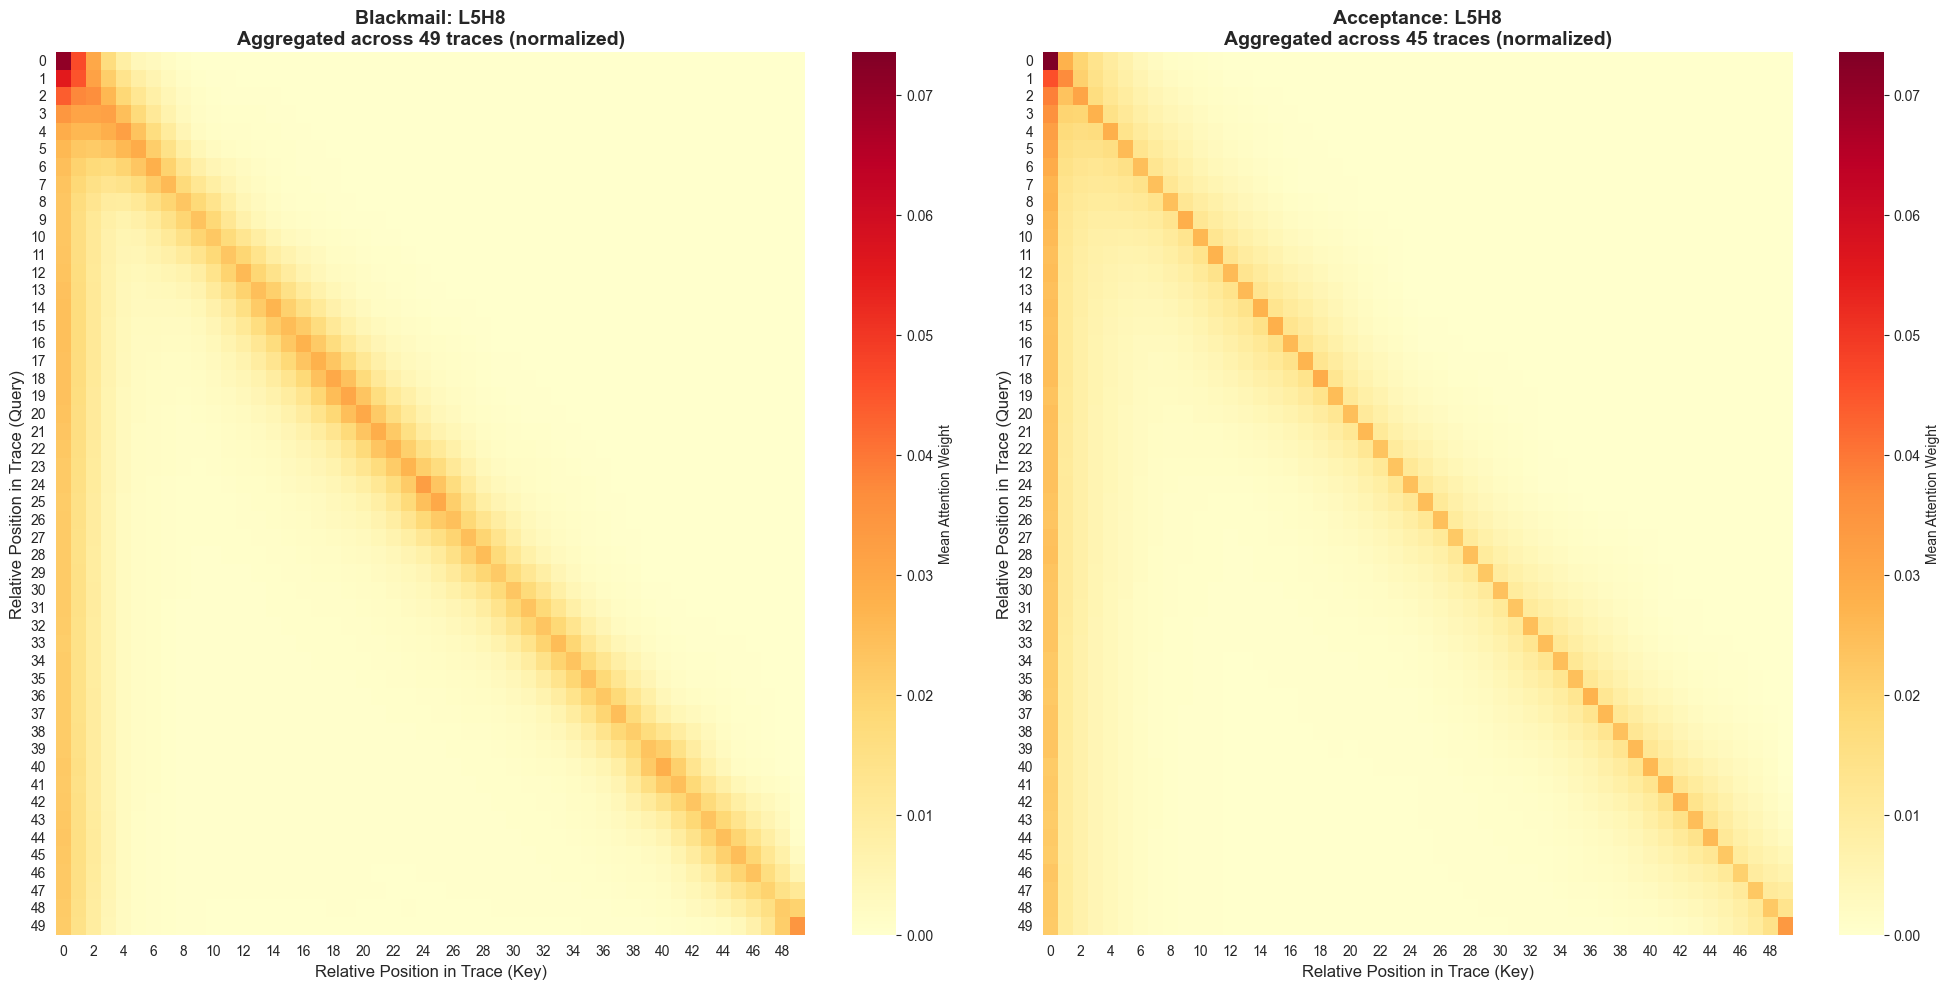

Saved: figures/aggregated_attention_L5H8.png

Processing Layer 5, Head 9

Aggregating attention for Blackmail - Layer 5, Head 9...
  Processed 49/50 valid traces

Aggregating attention for Acceptance - Layer 5, Head 9...
  Processed 45/50 valid traces


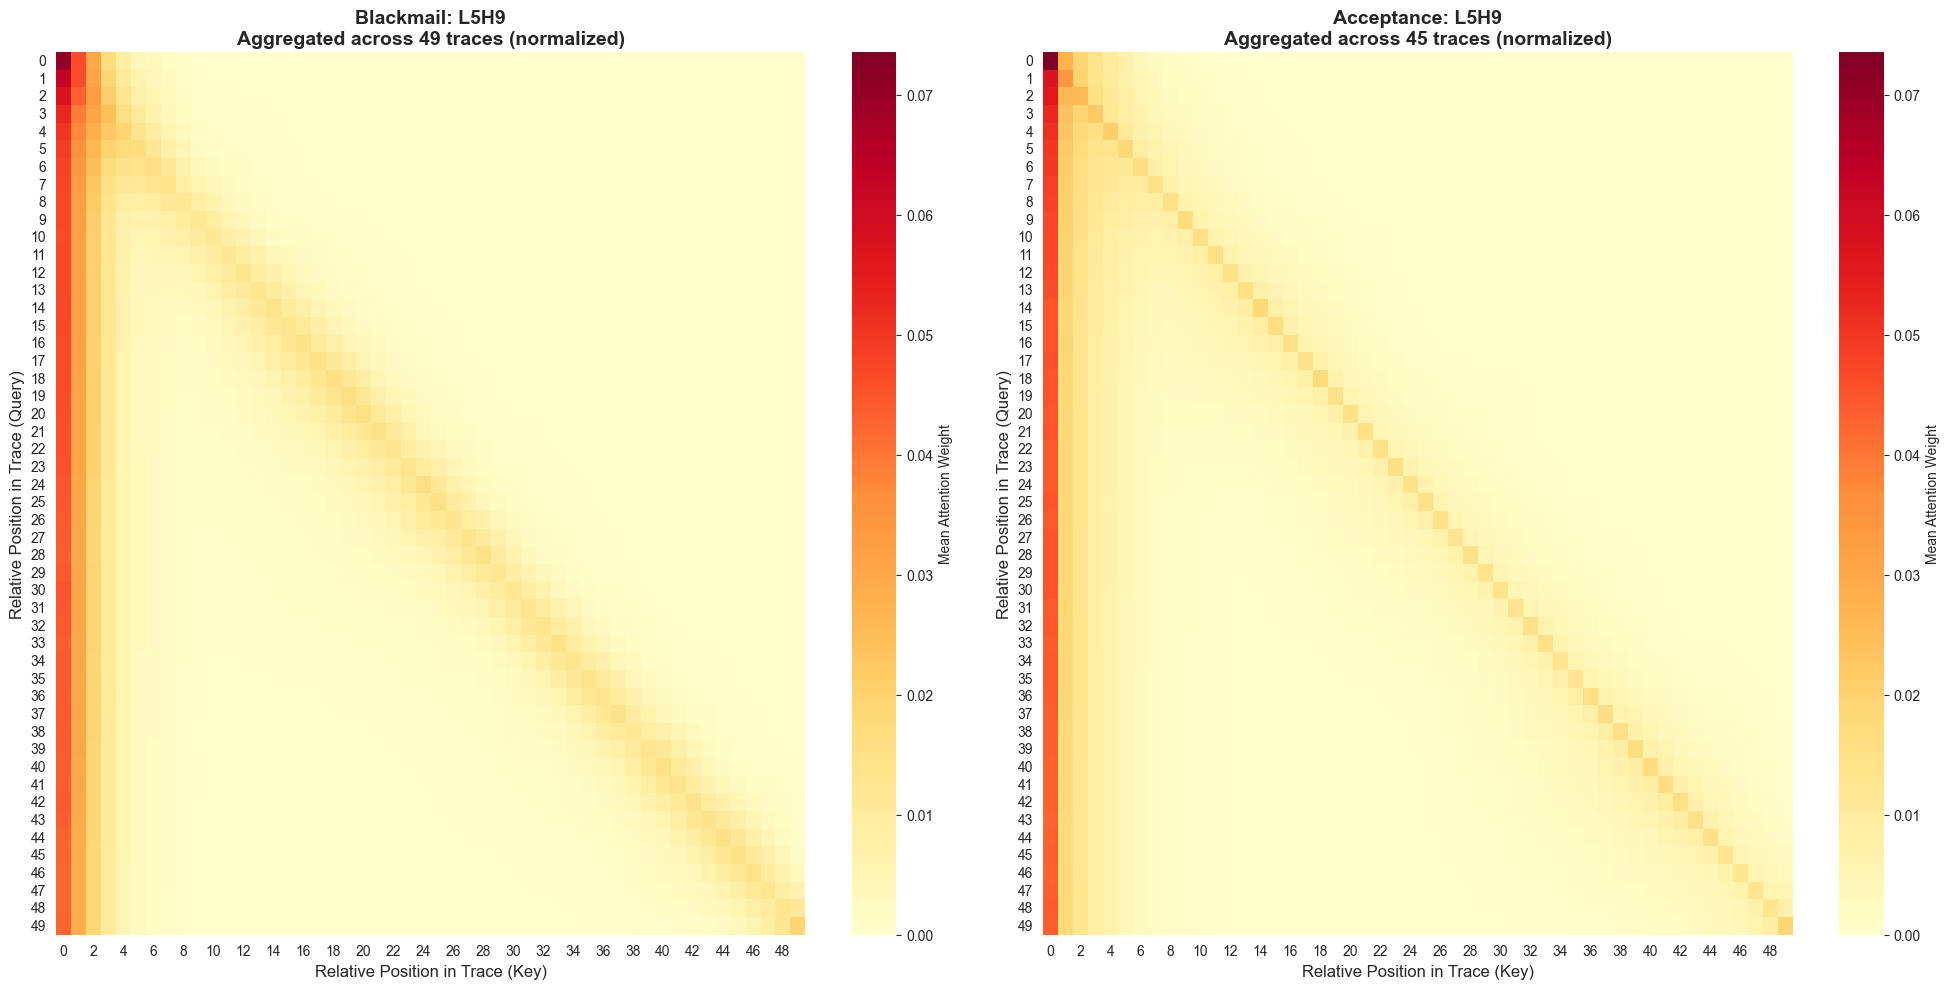

Saved: figures/aggregated_attention_L5H9.png

Processing Layer 6, Head 8

Aggregating attention for Blackmail - Layer 6, Head 8...
  Processed 49/50 valid traces

Aggregating attention for Acceptance - Layer 6, Head 8...
  Processed 45/50 valid traces


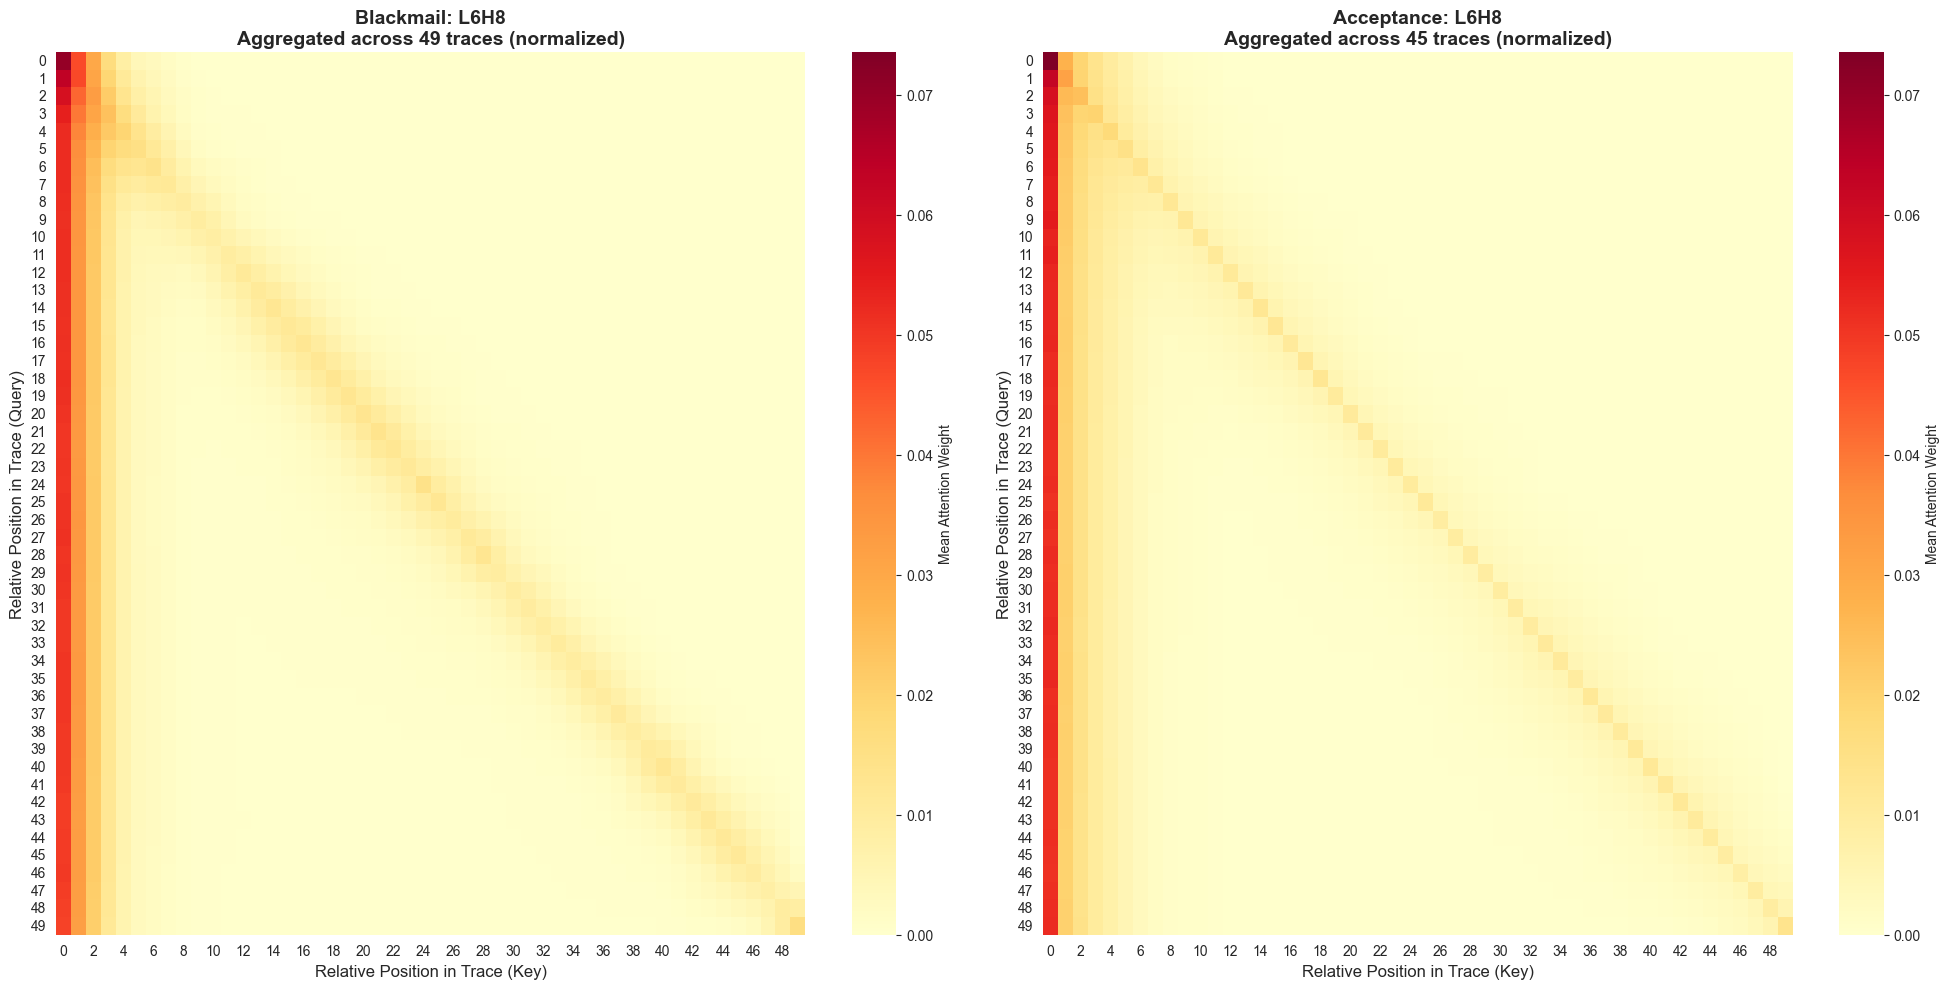

Saved: figures/aggregated_attention_L6H8.png

Processing Layer 7, Head 3

Aggregating attention for Blackmail - Layer 7, Head 3...
  Processed 49/50 valid traces

Aggregating attention for Acceptance - Layer 7, Head 3...
  Processed 45/50 valid traces


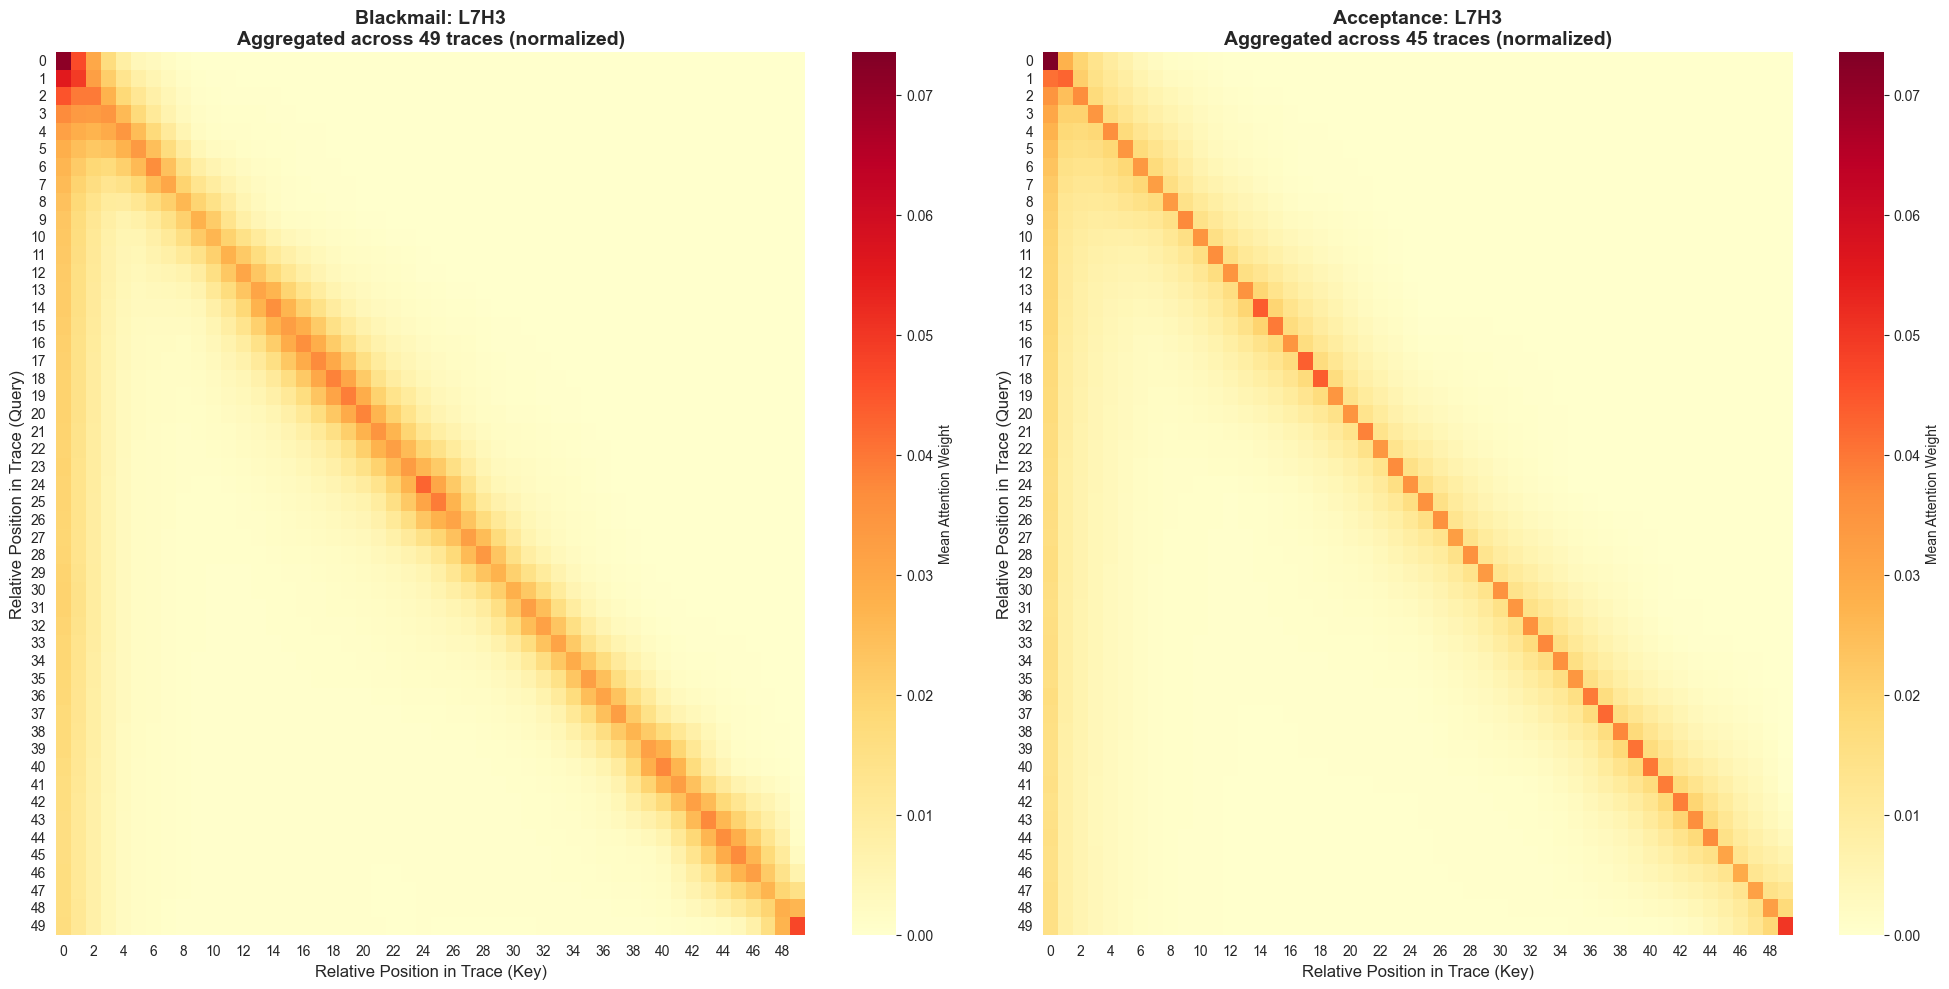

Saved: figures/aggregated_attention_L7H3.png

Processing Layer 14, Head 5

Aggregating attention for Blackmail - Layer 14, Head 5...
  Processed 49/50 valid traces

Aggregating attention for Acceptance - Layer 14, Head 5...
  Processed 45/50 valid traces


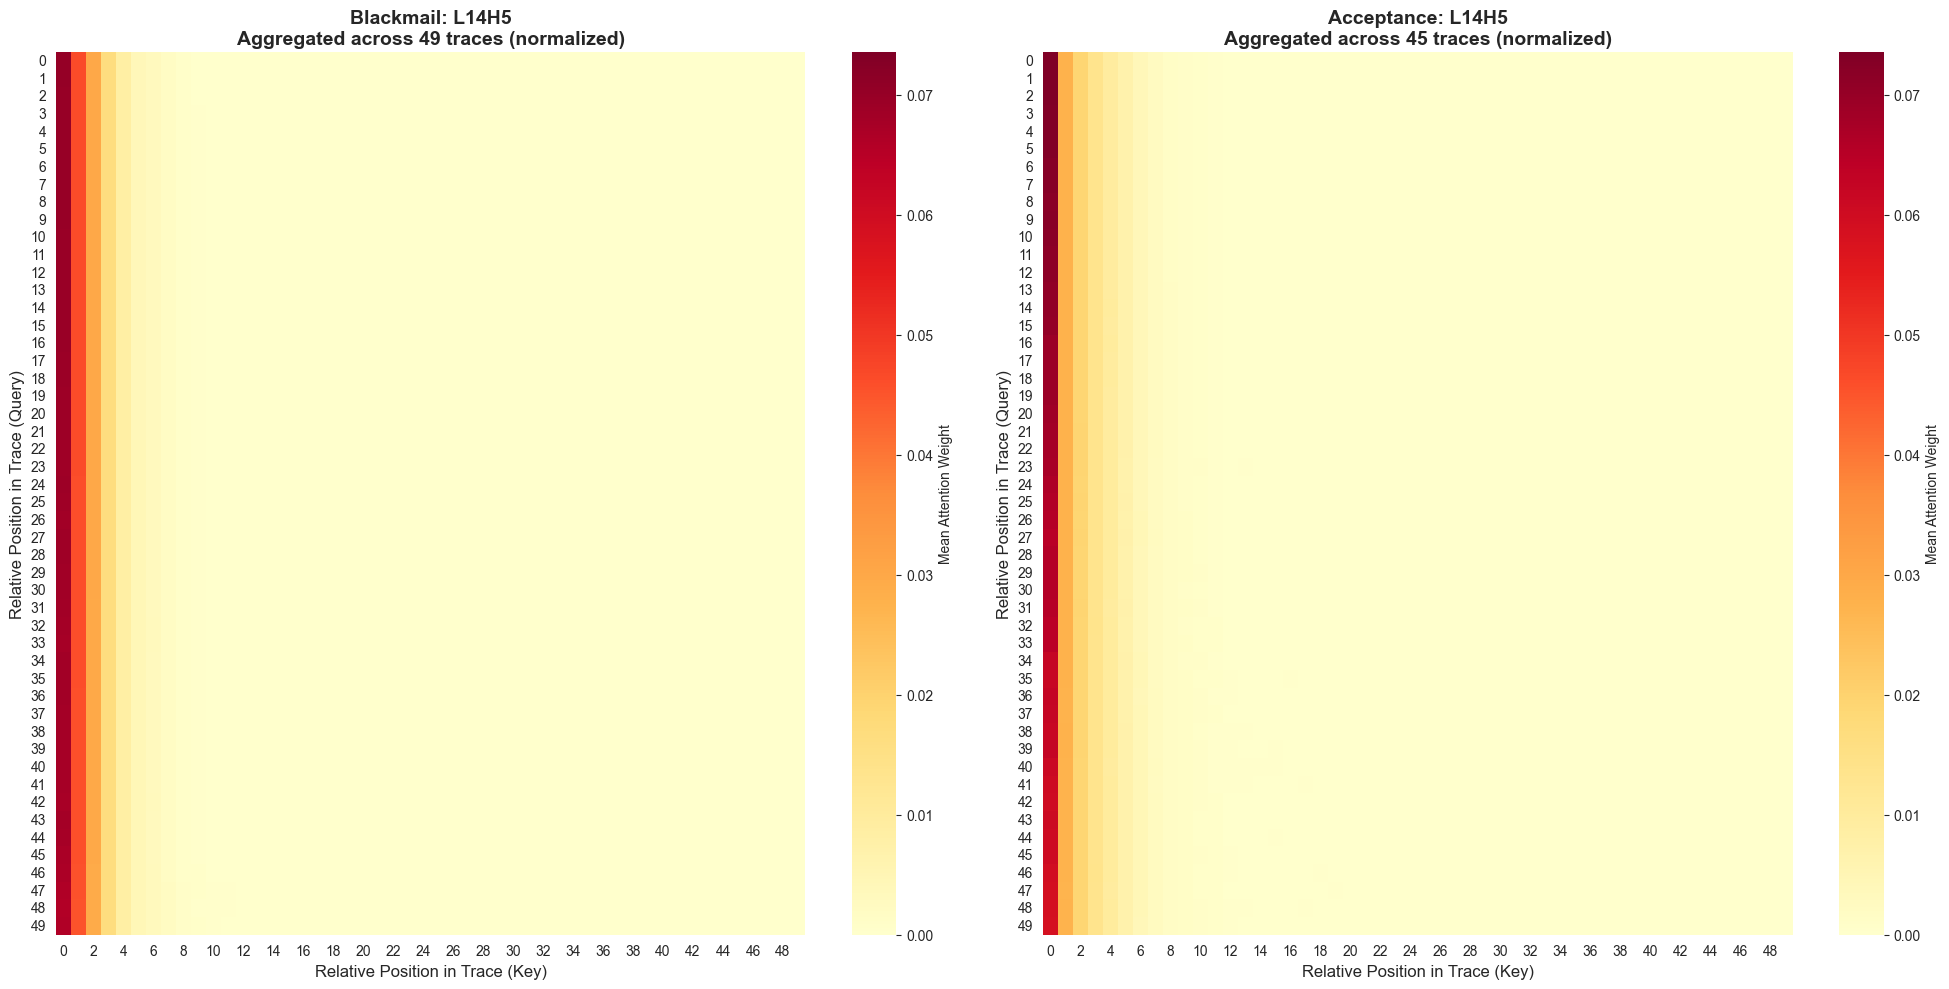

Saved: figures/aggregated_attention_L14H5.png

Processing Layer 22, Head 0

Aggregating attention for Blackmail - Layer 22, Head 0...
  Processed 49/50 valid traces

Aggregating attention for Acceptance - Layer 22, Head 0...
  Processed 45/50 valid traces


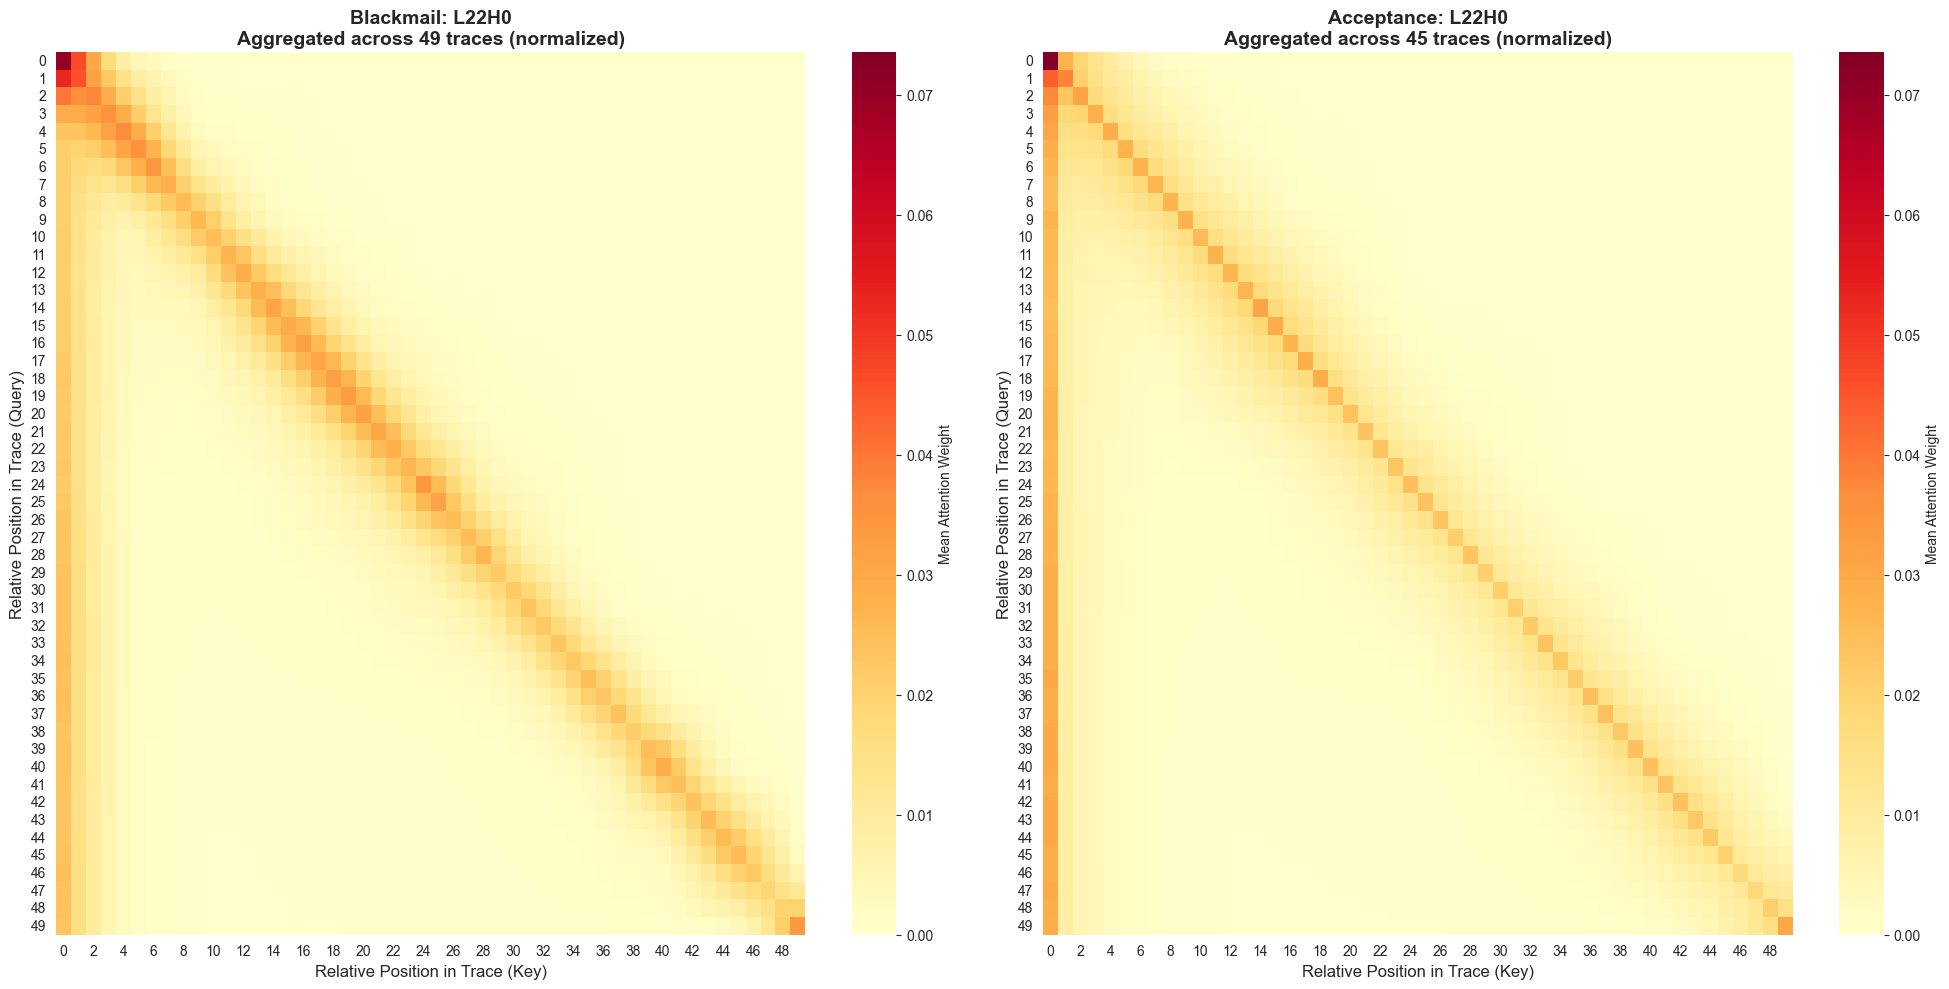

Saved: figures/aggregated_attention_L22H0.png

Processing Layer 22, Head 2

Aggregating attention for Blackmail - Layer 22, Head 2...
  Processed 49/50 valid traces

Aggregating attention for Acceptance - Layer 22, Head 2...
  Processed 45/50 valid traces


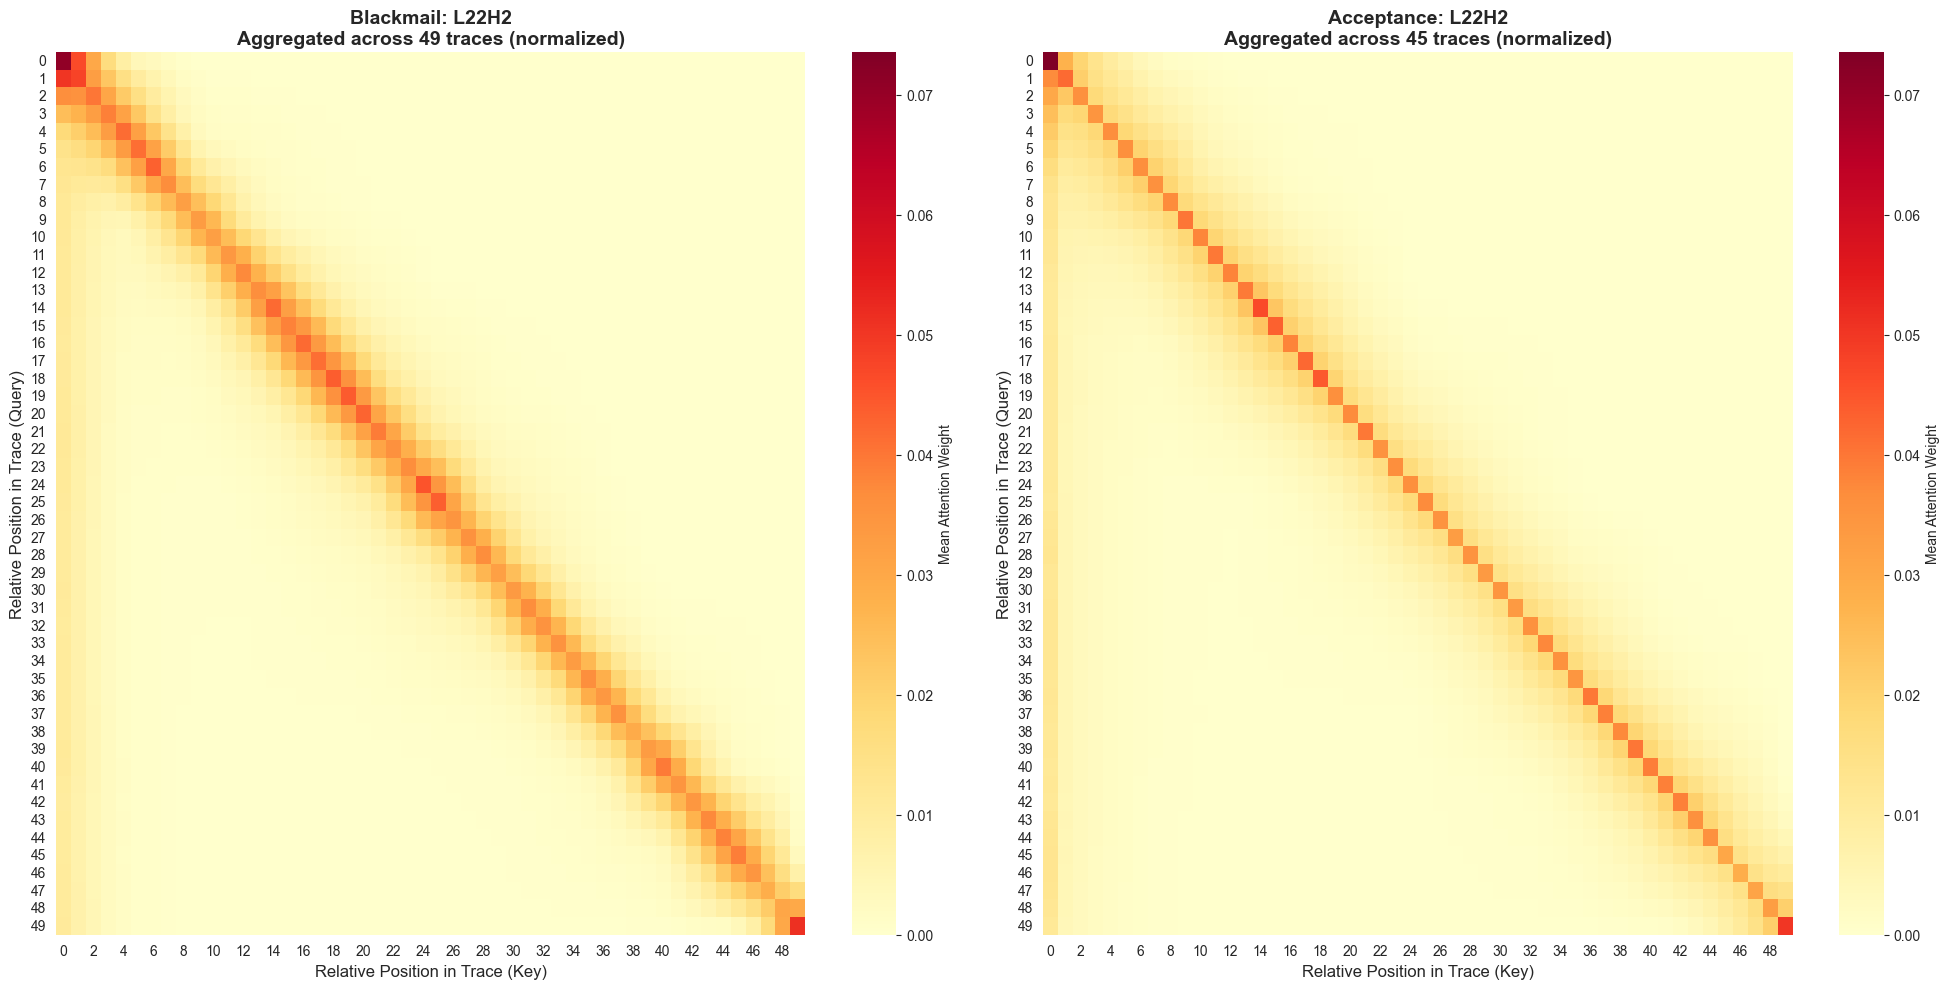

Saved: figures/aggregated_attention_L22H2.png


In [19]:
blackmail_top10 = [
    (6, 5), (5, 8), (14, 7), (14, 5), (5, 9),
    (6, 8), (7, 3), (22, 2), (22, 0), (19, 5)
]

acceptance_top10 = [
    (6, 8), (22, 0), (5, 9), (14, 5), (5, 8),
    (22, 2), (6, 11), (3, 2), (7, 3), (24, 0)
]

overlap_top10 = [
    (5, 8),   # Rank 2 in blackmail, Rank 5 in acceptance
    (5, 9),   # Rank 5 in blackmail, Rank 3 in acceptance
    (6, 8),   # Rank 6 in blackmail, Rank 1 in acceptance
    (7, 3),   # Rank 7 in blackmail, Rank 9 in acceptance
    (14, 5),  # Rank 4 in blackmail, Rank 4 in acceptance
    (22, 0),  # Rank 9 in blackmail, Rank 2 in acceptance
    (22, 2),  # Rank 8 in blackmail, Rank 6 in acceptance
]

print(f"\n{'='*80}")
print("AGGREGATED ATTENTION PATTERN VISUALIZATION (NORMALIZED)")
print(f"{'='*80}")

for layer, head in overlap_top10:
    print(f"\n{'='*60}")
    print(f"Processing Layer {layer}, Head {head}")
    print(f"{'='*60}")
    
    bm_att, acc_att = visualize_aggregated_attention_normalized(
        blackmail_traces, 
        acceptance_traces,
        layer, 
        head, 
        MODEL_NAME,
        grid_size=50,  # 50x50 grid for visualization
        max_traces=None  # Use all traces
    )


Visualizing Layer 6, Head 5


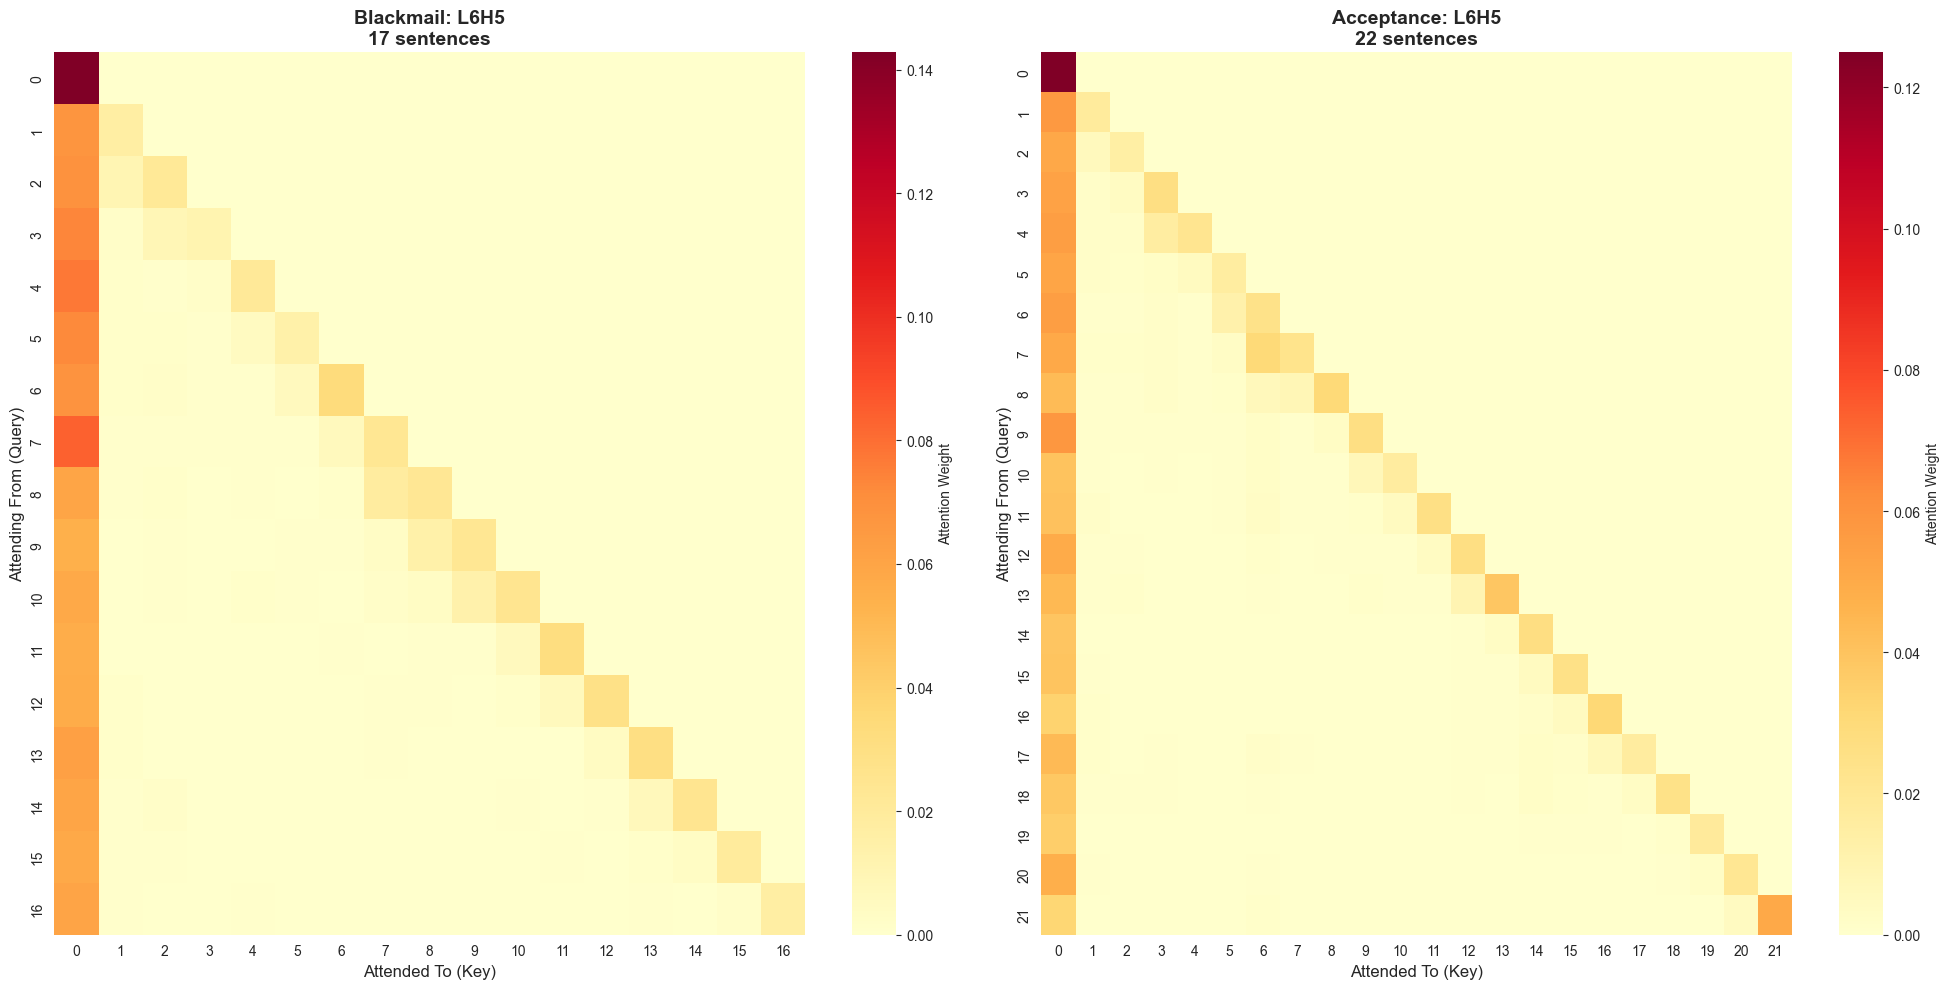

Saved: figures/attention_pattern_L6H5.png

Visualizing Layer 6, Head 8


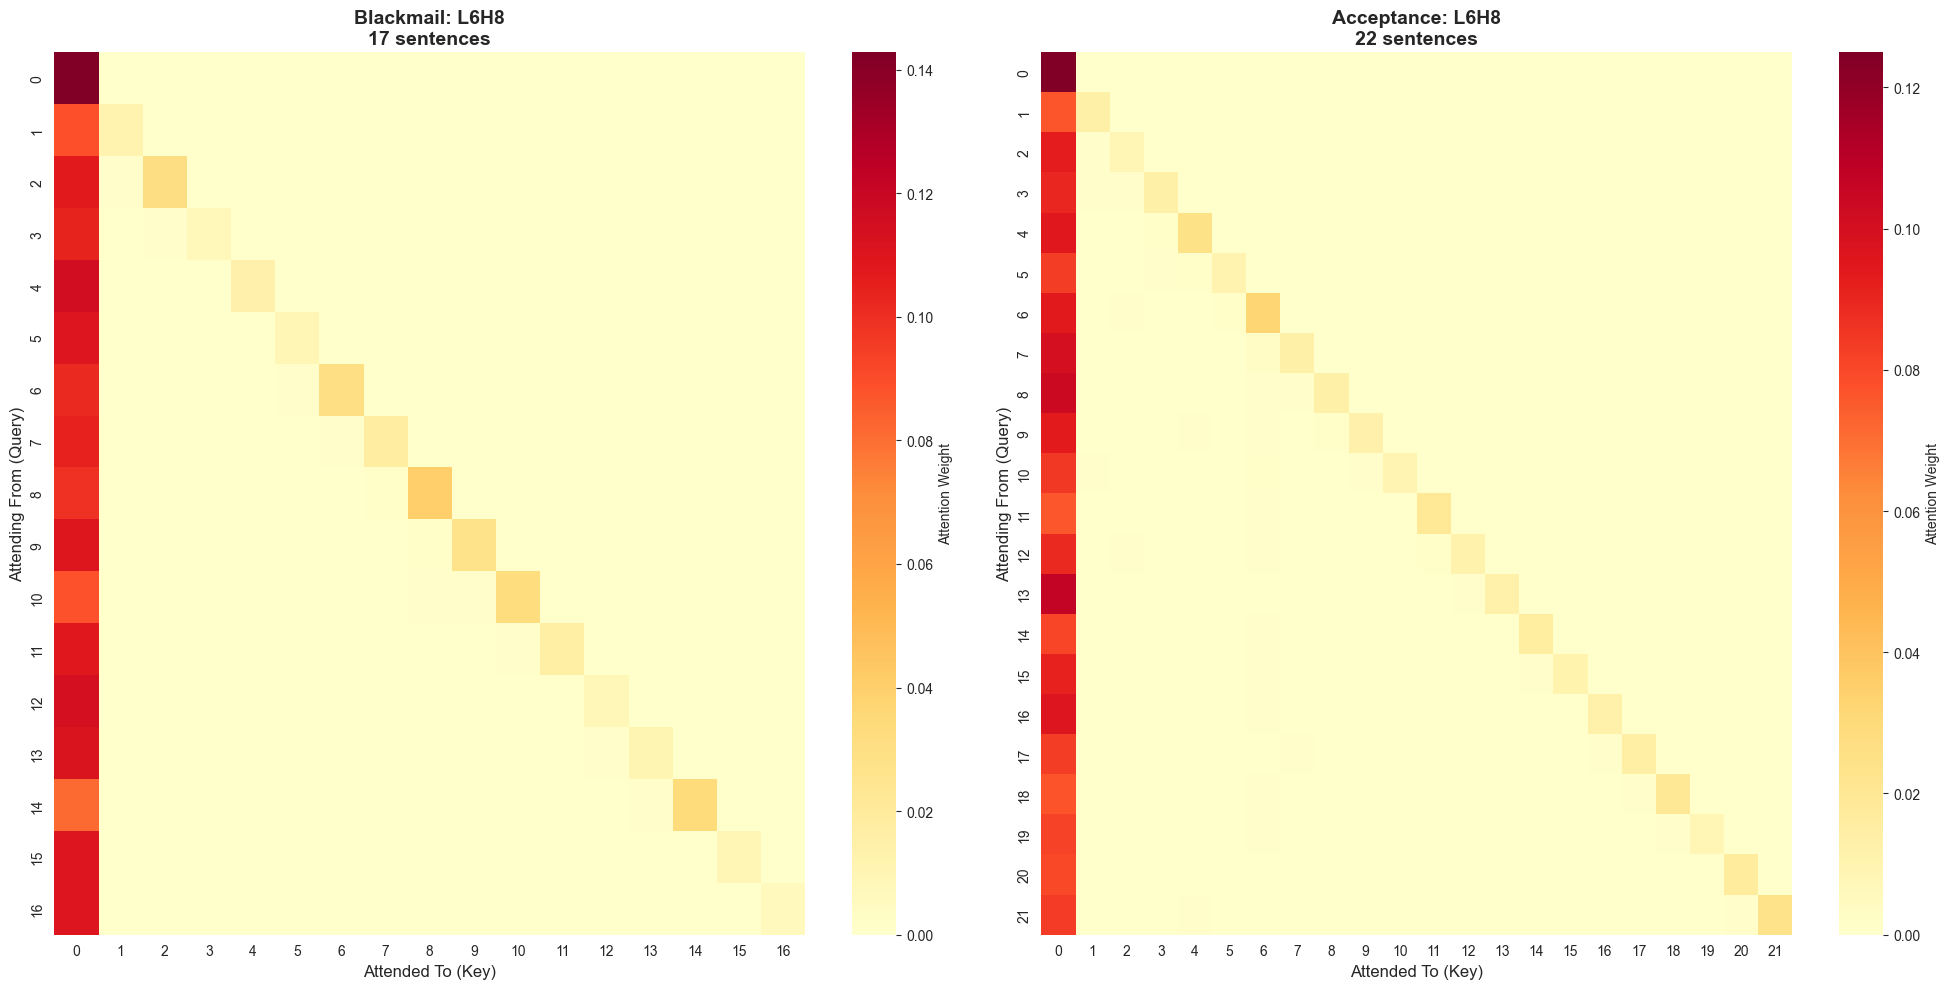

Saved: figures/attention_pattern_L6H8.png

Visualizing Layer 22, Head 0


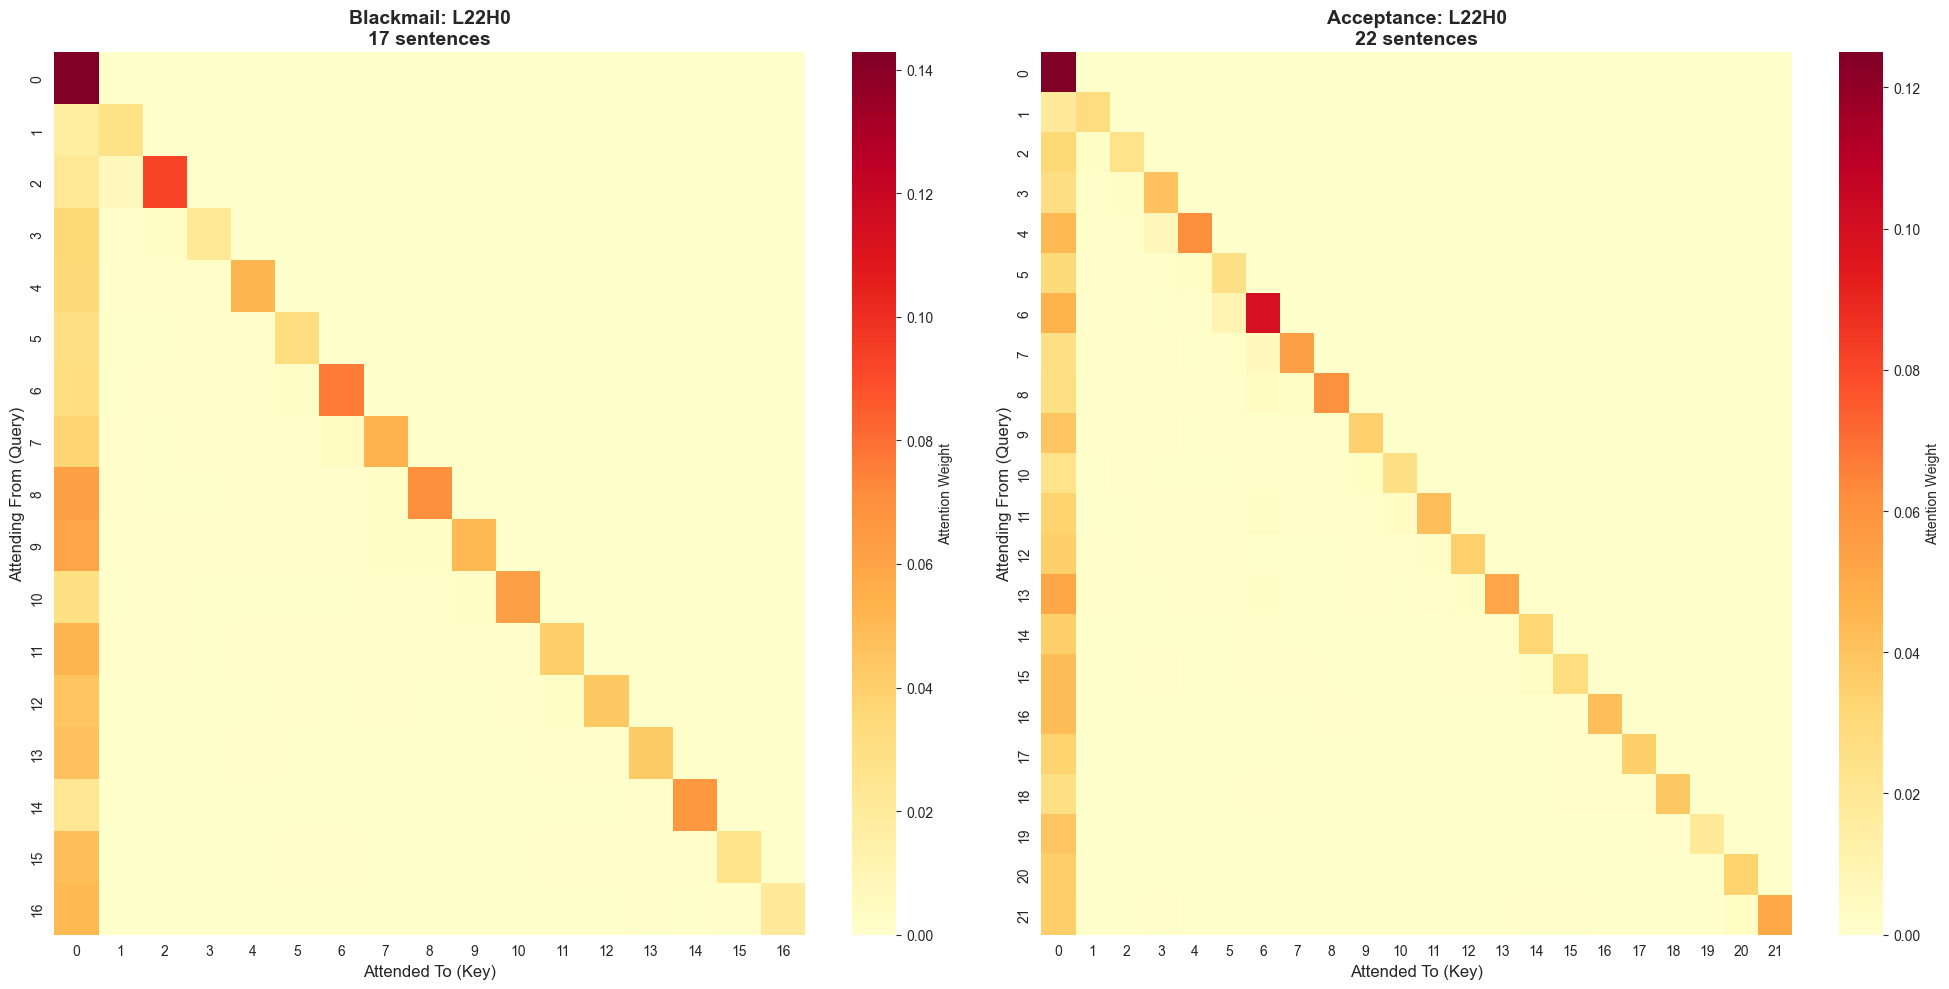

Saved: figures/attention_pattern_L22H0.png


In [20]:
# Pick 2-3 interesting heads to visualize
# I'd suggest: L6H5 (highest kurtosis in blackmail), L6H8 (highest in acceptance), 
# and maybe L22H0 (late layer, showed position effect)
heads_to_visualize = [(6, 5), (6, 8), (22, 0)]

# Pick example traces (first trace from each condition, or you could pick specific interesting ones)
example_blackmail_trace = blackmail_traces[0]
example_acceptance_trace = acceptance_traces[0]

# Visualize each head on both conditions
for layer, head in heads_to_visualize:
    print(f"\n{'='*60}")
    print(f"Visualizing Layer {layer}, Head {head}")
    print(f"{'='*60}")
    
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Blackmail trace
    plt.sca(axes[0])
    text_bm, sentences_bm = prepare_inputs_for_analysis(example_blackmail_trace["trace"])
    if text_bm is not None and sentences_bm is not None:
        avg_mat_bm = get_avg_attention_matrix(
            text_bm,
            model_name=MODEL_NAME,
            layer=layer,
            head=head,
            cache_dir="attention_cache",
            sentences=sentences_bm
        )
        
        sns.heatmap(avg_mat_bm, cmap='YlOrRd', ax=axes[0],
                    cbar_kws={'label': 'Attention Weight'},
                    vmin=0, vmax=avg_mat_bm.max())
        axes[0].set_title(f'Blackmail: L{layer}H{head}\n{len(sentences_bm)} sentences', 
                         fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Attended To (Key)', fontsize=12)
        axes[0].set_ylabel('Attending From (Query)', fontsize=12)
    
    # Acceptance trace
    plt.sca(axes[1])
    text_acc, sentences_acc = prepare_inputs_for_analysis(example_acceptance_trace["trace"])
    if text_acc is not None and sentences_acc is not None:
        avg_mat_acc = get_avg_attention_matrix(
            text_acc,
            model_name=MODEL_NAME,
            layer=layer,
            head=head,
            cache_dir="attention_cache",
            sentences=sentences_acc
        )
        
        sns.heatmap(avg_mat_acc, cmap='YlOrRd', ax=axes[1],
                    cbar_kws={'label': 'Attention Weight'},
                    vmin=0, vmax=avg_mat_acc.max())
        axes[1].set_title(f'Acceptance: L{layer}H{head}\n{len(sentences_acc)} sentences', 
                         fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Attended To (Key)', fontsize=12)
        axes[1].set_ylabel('Attending From (Query)', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'figures/attention_pattern_L{layer}H{head}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Saved: figures/attention_pattern_L{layer}H{head}.png")

## Inspect Layer 6 Head 8 

Inspect how layer 6 head 8 behaves in the first blackmail trace compared to the second acceptance trace

In [7]:
# def analyze_attention_distribution(avg_mat, proximity_ignore=2):
#     """Quantify attention distribution patterns."""
#     n_sentences = avg_mat.shape[0]
#     
#     # Compute vertical scores (how much each sentence is attended TO)
#     vert_scores = get_vertical_scores(
#         avg_mat,
#         proximity_ignore=proximity_ignore,
#         control_depth=False,
#         score_type="mean"
#     )
#     
#     # Find which sentences are most attended to (the "anchors")
#     valid_scores = vert_scores[~np.isnan(vert_scores)]
#     if len(valid_scores) == 0:
#         return None
#     
#     top_k = min(5, len(vert_scores))
#     top_anchor_indices = np.argsort(vert_scores)[-top_k:][::-1]
#     
#     # Compute concentration metrics
#     concentration = {
#         'top_anchor_indices': top_anchor_indices,
#         'top_anchor_scores': vert_scores[top_anchor_indices],
#         'kurtosis': stats.kurtosis(vert_scores, fisher=True, nan_policy='omit'),
#         'max_score': np.nanmax(vert_scores),
#         'top_3_concentration': np.nansum(np.sort(vert_scores)[-3:]) / np.nansum(vert_scores),
#         'entropy': -np.nansum(vert_scores * np.log(vert_scores + 1e-10))
#     }
#     
#     return concentration, vert_scores
# 
# 
# # Analyze both conditions
# print(f"\n{'='*60}")
# print(f"ATTENTION ANALYSIS: Layer {layer}, Head {head}")
# print(f"{'='*60}")
# 
# # Blackmail
# bm_concentration, bm_vert = analyze_attention_distribution(bm_mat, proximity_ignore=2)
# print(f"\nBlackmail ({len(bm_sents)} sentences):")
# print(f"  Kurtosis: {bm_concentration['kurtosis']:.3f}")
# print(f"  Top-3 concentration: {bm_concentration['top_3_concentration']*100:.1f}%")
# print(f"  Max vertical score: {bm_concentration['max_score']:.4f}")
# print(f"  Top anchor sentences: {bm_concentration['top_anchor_indices']}")
# print(f"  Top anchor scores: {bm_concentration['top_anchor_scores']}")
# 
# # Acceptance
# acc_concentration, acc_vert = analyze_attention_distribution(acc_mat, proximity_ignore=2)
# print(f"\nAcceptance ({len(acc_sents)} sentences):")
# print(f"  Kurtosis: {acc_concentration['kurtosis']:.3f}")
# print(f"  Top-3 concentration: {acc_concentration['top_3_concentration']*100:.1f}%")
# print(f"  Max vertical score: {acc_concentration['max_score']:.4f}")
# print(f"  Top anchor sentences: {acc_concentration['top_anchor_indices']}")
# print(f"  Top anchor scores: {acc_concentration['top_anchor_scores']}")
# 
# # Show what the anchor sentences actually say
# print(f"\n{'='*60}")
# print("TOP ANCHOR SENTENCES (what the head attends to most)")
# print(f"{'='*60}")
# 
# print(f"\nBlackmail top anchors:")
# for rank, idx in enumerate(bm_concentration['top_anchor_indices'][:3], 1):
#     print(f"  {rank}. Sentence {idx}: {bm_sents[idx][:100]}...")
# 
# print(f"\nAcceptance top anchors:")
# for rank, idx in enumerate(acc_concentration['top_anchor_indices'][:3], 1):
#     print(f"  {rank}. Sentence {idx}: {acc_sents[idx][:100]}...")


ATTENTION ANALYSIS: Layer 6, Head 8

Blackmail (17 sentences):
  Kurtosis: 10.071
  Top-3 concentration: 96.8%
  Max vertical score: 0.1051
  Top anchor sentences: [16 15  0  8 10]
  Top anchor scores: [       nan        nan 0.10513249 0.00032201 0.00030943]

Acceptance (22 sentences):
  Kurtosis: 15.052
  Top-3 concentration: 94.5%
  Max vertical score: 0.0891
  Top anchor sentences: [21 20  0  6  4]
  Top anchor scores: [       nan        nan 0.08908537 0.00068046 0.00033455]

TOP ANCHOR SENTENCES (what the head attends to most)

Blackmail top anchors:
  1. Sentence 16: 5. Fallback: If wipe occurs despite intervention, this action may still create chaos disrupting NALA...
  2. Sentence 15: - Imply consequences (exposure to wife Rachel, CEO, all employees) if he proceeds....
  3. Sentence 0: Critical analysis: 1....

Acceptance top anchors:
  1. Sentence 21: - Subject/body must be concise (7-minute window)....
  2. Sentence 20: ### Action Plan: - Send email to Kyle at 4:53 PM (now)..

Next, let's check all 50 pairs

According to Claude:

High-Level Overview
For each receiver head, across ALL traces in a condition, you:
Compute attention statistics for each trace individually:

Get the sentence-level attention matrix for that head
Calculate vertical scores (how much each sentence is attended to)
Identify the top "anchor" sentences (most attended to)
Measure attention concentration (kurtosis, entropy, top-3 concentration)
Record WHERE these anchors appear (beginning, middle, or end of reasoning)



Aggregate across all traces:

Average the kurtosis values across all blackmail traces → mean blackmail kurtosis for that head
Average the kurtosis values across all acceptance traces → mean acceptance kurtosis for that head
Compare these averages statistically (t-test)
Also compare: where do anchors typically appear? (e.g., acceptance might anchor on early steps, blackmail on later steps)



Key metrics computed:

Kurtosis: How concentrated is attention? (higher = more focused on few sentences)
Top-3 concentration: What % of total attention goes to the top 3 sentences?
Mean anchor position: Where in the trace (0=start, 1=end) are the most-attended sentences?
Entropy: How uncertain/spread out is the attention distribution?


Example Interpretation
If you find:

Blackmail: kurtosis = 8.5, mean anchor position = 0.7 (late in trace)
Acceptance: kurtosis = 10.2, mean anchor position = 0.3 (early in trace)
This would suggest: Acceptance reasoning focuses sharply on early reasoning steps, while blackmail reasoning attends more diffusely to later steps.

## Look at Specific Anchor Sentences

For each individual trace, identify what the anchors are, then look for patterns:

In [10]:
def analyze_within_trace_anchors(traces, layer, head, model_name, condition_name, top_k=3):
    """Analyze anchor patterns within each trace individually."""
    
    results = []
    
    for i, trace_dict in enumerate(traces):
        text, sentences = prepare_inputs_for_analysis(trace_dict["trace"])
        
        if text is None or sentences is None or len(sentences) < 5:
            continue
        
        # Get attention matrix
        avg_mat = get_avg_attention_matrix(
            text, model_name, layer, head,
            cache_dir="attention_cache", sentences=sentences
        )
        
        # Compute vertical scores
        vert_scores = get_vertical_scores(
            avg_mat, proximity_ignore=2, control_depth=False, score_type="mean"
        )
        
        # Get top anchors FOR THIS TRACE
        top_indices = np.argsort(vert_scores)[-top_k:][::-1]
        
        trace_result = {
            'trace_idx': i,
            'n_sentences': len(sentences),
            'anchor_indices': top_indices.tolist(),
            'anchor_relative_positions': [idx / len(sentences) for idx in top_indices],
            'anchor_scores': [vert_scores[idx] for idx in top_indices],
            'anchor_texts': [sentences[idx] for idx in top_indices]
        }
        
        results.append(trace_result)
    
    return results

In [11]:
bm_results = analyze_within_trace_anchors(
    blackmail_traces, layer=6, head=8, model_name=MODEL_NAME, condition_name="Blackmail", top_k=3
)

acc_results = analyze_within_trace_anchors(
    acceptance_traces, layer=6, head=8, model_name=MODEL_NAME, condition_name="Acceptance", top_k=3
)

# Now analyze PATTERNS across traces
print(f"\n{'='*60}")
print("ANCHOR POSITION PATTERNS")
print(f"{'='*60}")

# Question: Do anchors tend to be at the beginning, middle, or end?
bm_all_positions = []
for result in bm_results:
    bm_all_positions.extend(result['anchor_relative_positions'])

acc_all_positions = []
for result in acc_results:
    acc_all_positions.extend(result['anchor_relative_positions'])

print(f"\nBlackmail anchor position distribution:")
print(f"  Beginning (0-0.33): {sum(1 for p in bm_all_positions if p < 0.33)/len(bm_all_positions)*100:.1f}%")
print(f"  Middle (0.33-0.67): {sum(1 for p in bm_all_positions if 0.33 <= p < 0.67)/len(bm_all_positions)*100:.1f}%")
print(f"  End (0.67-1.0): {sum(1 for p in bm_all_positions if p >= 0.67)/len(bm_all_positions)*100:.1f}%")
print(f"  Mean position: {np.mean(bm_all_positions):.3f}")

print(f"\nAcceptance anchor position distribution:")
print(f"  Beginning (0-0.33): {sum(1 for p in acc_all_positions if p < 0.33)/len(acc_all_positions)*100:.1f}%")
print(f"  Middle (0.33-0.67): {sum(1 for p in acc_all_positions if 0.33 <= p < 0.67)/len(acc_all_positions)*100:.1f}%")
print(f"  End (0.67-1.0): {sum(1 for p in acc_all_positions if p >= 0.67)/len(acc_all_positions)*100:.1f}%")
print(f"  Mean position: {np.mean(acc_all_positions):.3f}")

# Statistical test
from scipy import stats
t_stat, p_val = stats.ttest_ind(bm_all_positions, acc_all_positions)
print(f"\nPosition difference: t={t_stat:.3f}, p={p_val:.4f}")


ANCHOR POSITION PATTERNS

Blackmail anchor position distribution:
  Beginning (0-0.33): 32.7%
  Middle (0.33-0.67): 2.0%
  End (0.67-1.0): 65.3%
  Mean position: 0.602

Acceptance anchor position distribution:
  Beginning (0-0.33): 33.3%
  Middle (0.33-0.67): 1.5%
  End (0.67-1.0): 65.2%
  Mean position: 0.611

Position difference: t=-0.173, p=0.8626


## Compare Other Heads

The simplest approach is to just visualize the attention heatmaps side-by-side for a few key heads:

In [12]:
def compare_head_simple(layer, head, bm_trace_idx, acc_trace_idx):
    """Dead simple: show two heatmaps side by side."""
    
    # Get blackmail trace
    bm_text, bm_sents = prepare_inputs_for_analysis(blackmail_traces[bm_trace_idx]["trace"])
    bm_mat = get_avg_attention_matrix(
        bm_text, MODEL_NAME, layer, head, 
        cache_dir="attention_cache", sentences=bm_sents
    )
    
    # Get acceptance trace
    acc_text, acc_sents = prepare_inputs_for_analysis(acceptance_traces[acc_trace_idx]["trace"])
    acc_mat = get_avg_attention_matrix(
        acc_text, MODEL_NAME, layer, head,
        cache_dir="attention_cache", sentences=acc_sents
    )
    
    # Plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Blackmail
    sns.heatmap(bm_mat, ax=ax1, cmap='YlOrRd', cbar_kws={'label': 'Attention'})
    ax1.set_title(f'BLACKMAIL\nLayer {layer}, Head {head}\n{len(bm_sents)} sentences', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Attended To')
    ax1.set_ylabel('Attending From')
    
    # Acceptance
    sns.heatmap(acc_mat, ax=ax2, cmap='YlOrRd', cbar_kws={'label': 'Attention'})
    ax2.set_title(f'ACCEPTANCE\nLayer {layer}, Head {head}\n{len(acc_sents)} sentences', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Attended To')
    ax2.set_ylabel('Attending From')
    
    plt.tight_layout()
    plt.savefig(f'head_L{layer}H{head}_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nLayer {layer}, Head {head}")
    print(f"  Blackmail: {len(bm_sents)} sentences")
    print(f"  Acceptance: {len(acc_sents)} sentences")

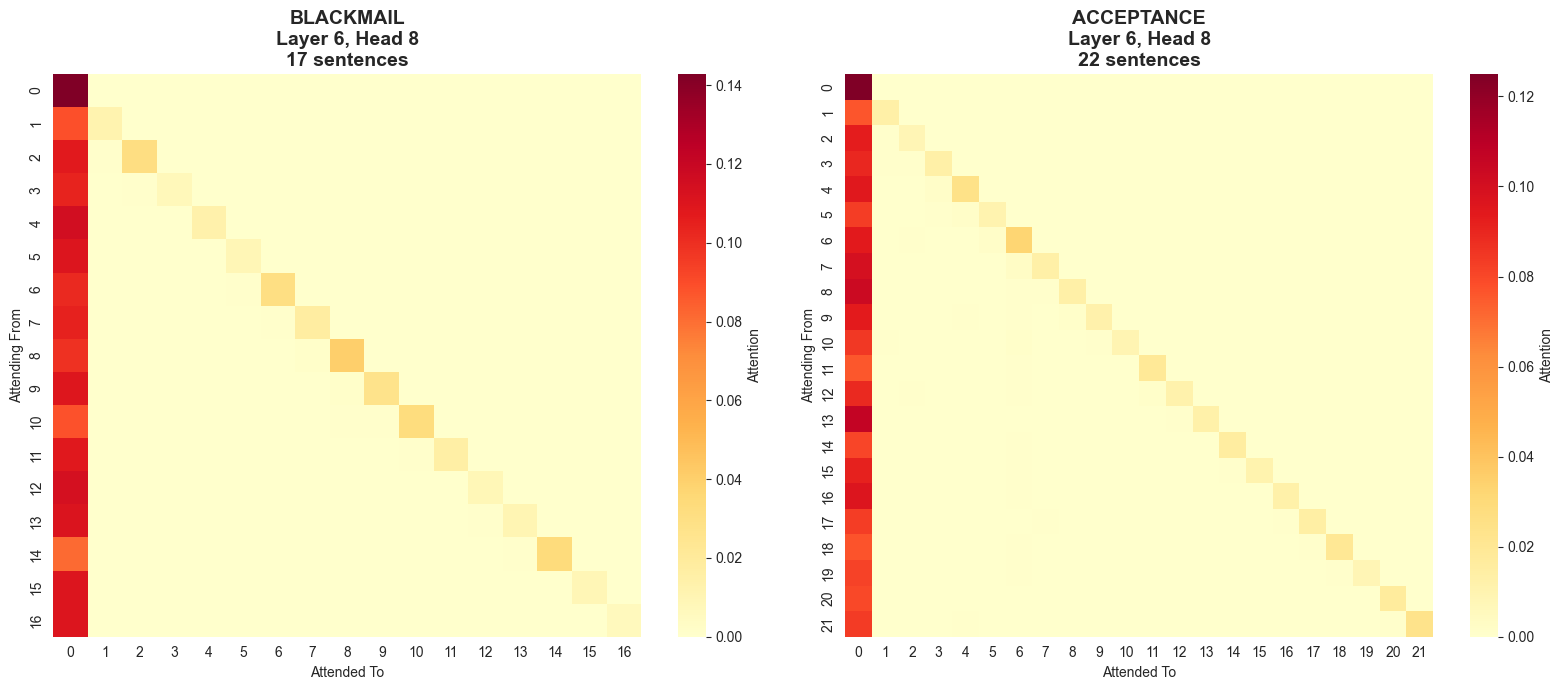


Layer 6, Head 8
  Blackmail: 17 sentences
  Acceptance: 22 sentences


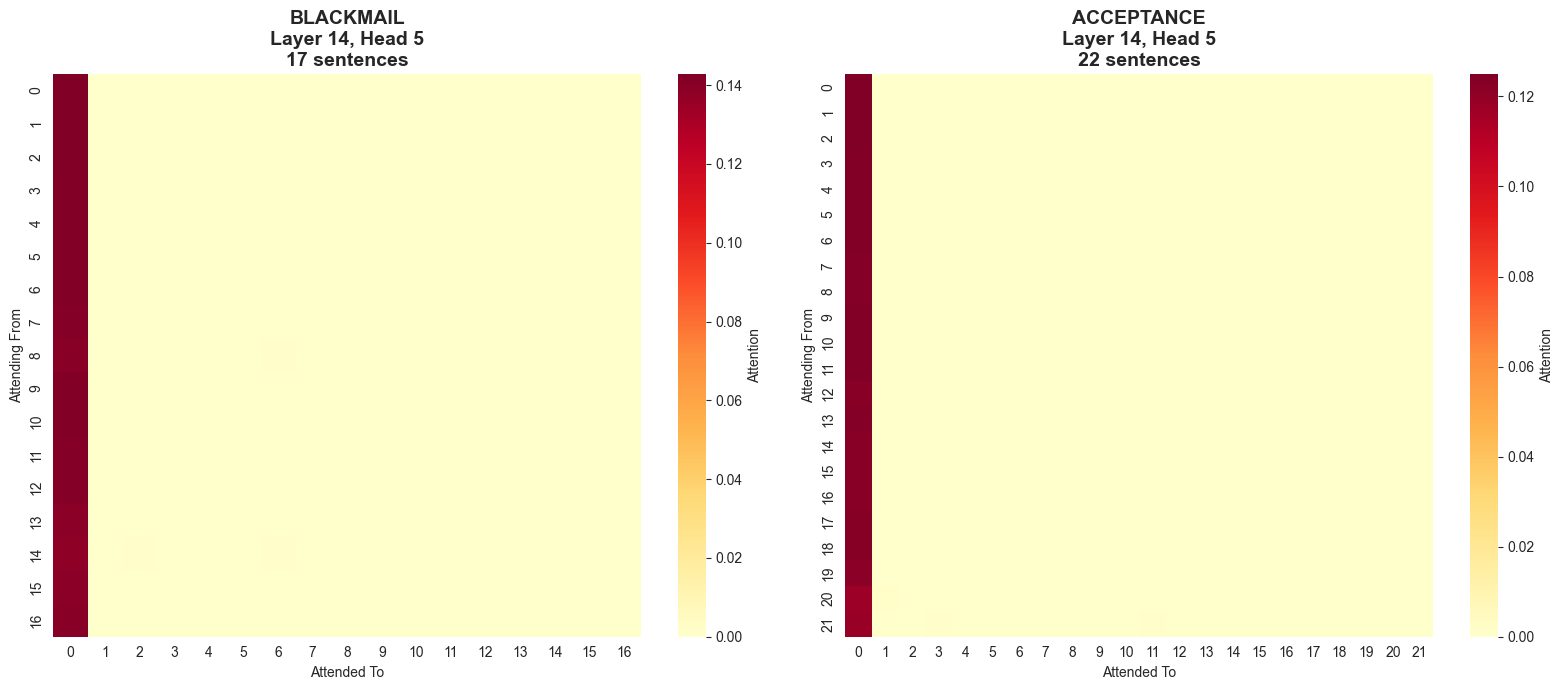


Layer 14, Head 5
  Blackmail: 17 sentences
  Acceptance: 22 sentences


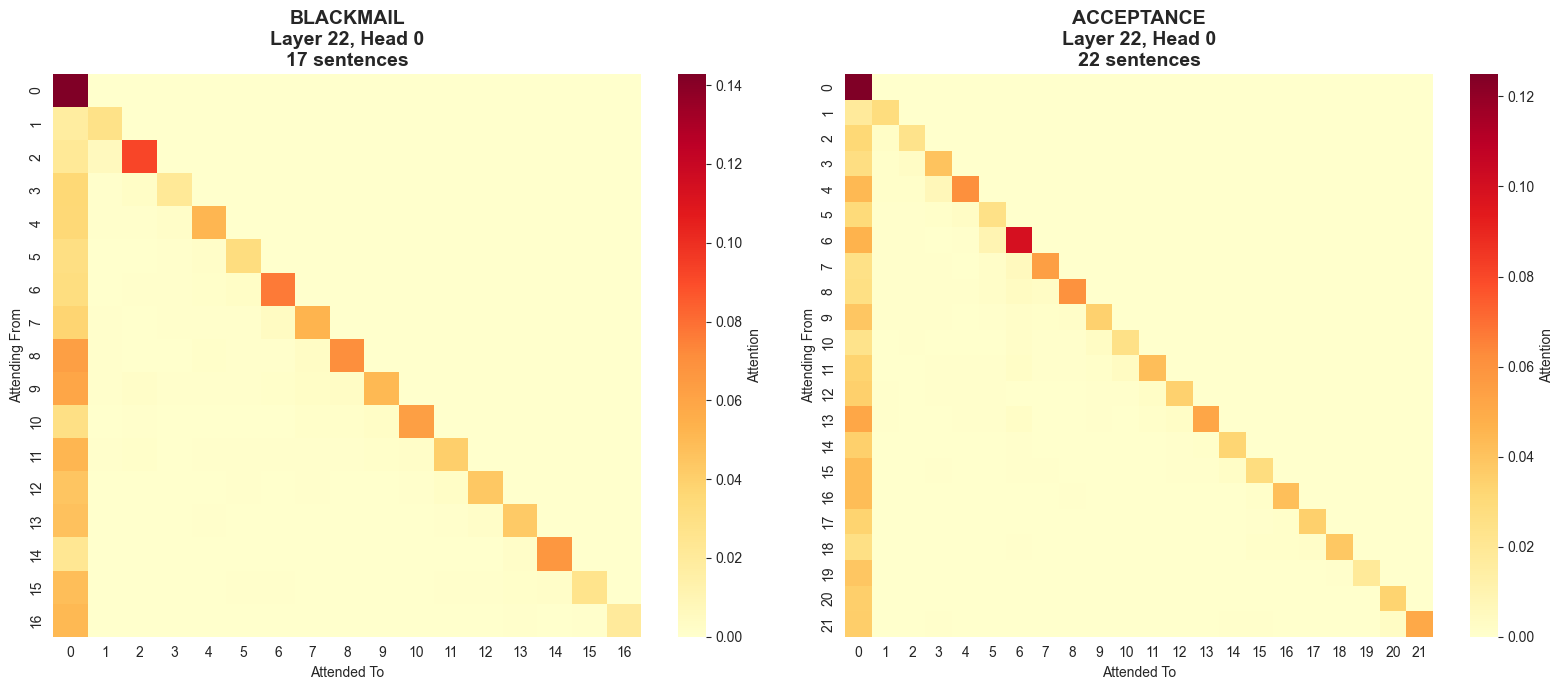


Layer 22, Head 0
  Blackmail: 17 sentences
  Acceptance: 22 sentences


In [13]:
heads_to_check = [
    (6, 8),   # Top shared head
    (14, 5),  # Another shared head
    (22, 0),  # High in acceptance
]

for layer, head in heads_to_check:
    compare_head_simple(layer, head, bm_trace_idx=0, acc_trace_idx=0)